In [1]:
%config IPCompleter.greedy=True

In [1]:
import torch
from torchvision.utils import make_grid
from fcn import FCN
from dataloader import getDataLoader
import matplotlib.pyplot as plt
from PIL import Image
import pickle

batch_size = 4
device = torch.device("cuda:0")

net = FCN(upsample="32", class_num=21)
net.load_state_dict(torch.load("Training/3/best-FCN.pth"))
net.to(device)
net.eval()

train_loader, val_loader = getDataLoader(batch_size= batch_size, num_workers=4)
print(len(train_loader), len(val_loader))
with open("./palette.p","rb") as f:
    palette = pickle.load(f) 



2839 87


In [2]:
from util import deNormImg
def batchToPIL(batch_imgs):
    img_list = []
    for idx in range(batch_imgs.shape[0]):
        img_list.append(batch_imgs[idx])
    grid_batch = torch.cat(img_list, dim=0).detach().numpy()
    grid_batch = grid_batch.astype(np.uint8)
    # print(grid_batch.shape)
    pil_grid= Image.fromarray(grid_batch, mode = "P")
    pil_grid.putpalette(palette)
    return pil_grid
def batchVisualization(batch_img, batch_pred, batch_label):
    plt.figure(figsize=(8,8))
    plt.subplot(1,3,1)
    imgs = make_grid(batch_img,nrow = 1).permute((1,2,0)).detach().numpy()
    plt.imshow(deNormImg(imgs))
    plt.subplot(1,3,2)
    pred = torch.argmax(batch_pred, dim = 1)
    pred = batchToPIL(pred)
    plt.imshow(pred)
    plt.subplot(1,3,3)
    labels = batchToPIL(batch_label)
    plt.imshow(labels)

In [3]:
import numpy as np
from tqdm.notebook import tqdm
from util import calConfusionMatrix, calMetric
from dataloader import getTestData

img_1st = None
label_1st = None
pred_1st = None
with torch.no_grad():
    conf_mat = np.zeros((21,21))
    for idx, data in tqdm(enumerate(val_loader), total = len(val_loader)):
        img, label = data
        output= net(img.to(device)).detach().cpu()
        # if idx ==1:
        #     img_1st, label_1st, pred_1st = img, label, output
        output = torch.argmax(output,dim = 1)
        conf_mat = calConfusionMatrix(output, label, 21,conf_mat)
    pixel_acc, mean_acc, mean_iu, freq_weighted_iu = calMetric(conf_mat)

    img_batch,label_batch = getTestData()
    pred_batch = net(img_batch.to(device)).detach().cpu()


pixel:0.8794273452817074,acc:0.7249069044563572,mean_iu:0.570200574484416,freq:0.801575751364219


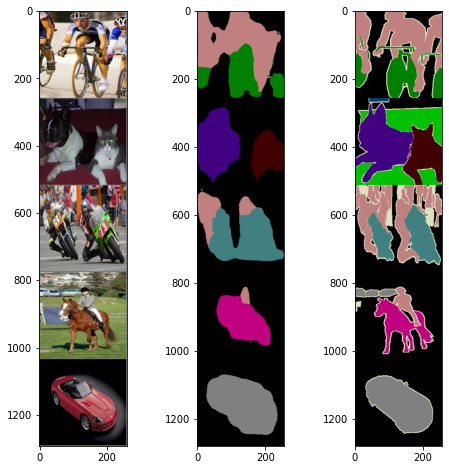

In [6]:
print(f"pixel:{pixel_acc},acc:{mean_acc},mean_iu:{mean_iu},freq:{freq_weighted_iu}")
batchVisualization(img_batch,pred_batch, label_batch)
plt.savefig("Fig/best-FCN32.png")

In [41]:
### pickle에 palette, Selected Image 저장
import pickle
from PIL import Image
test_data= ['2007_000129', '2007_001763', '2007_005173', '2007_005331', '2007_006277']
with open("sample_image_name.p","wb") as f:
    pickle.dump(test_data,f)

sample_image= Image.open("Datas/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png")
with open("palette.p","wb") as f:
    pickle.dump(sample_image.getpalette(),f)
palette = sample_image.getpalette()

In [48]:
'''Data Finement(?): SBD to train, PascalVOC2012 which is not included in SBD to val
label as png, img to jpg
'''
dir = "Datas/SBD_VOC/"
os.makedirs(dir,exist_ok= True)
os.makedirs(dir+"img")
os.makedirs(dir+"label")

train_data =[]
with open("Datas/benchmark_RELEASE/dataset/train.txt","rb") as f:
    for line in f.readlines():
        string_byte = line.strip()
        string = line.strip().decode('utf-8')
        train_data.append(string_byte)
        os.rename(f"Datas/benchmark_RELEASE/dataset/img/"+string+".jpg",dir+"img/"+string+".jpg")
        img = loadmat("Datas/benchmark_RELEASE/dataset/cls/"+string+".mat")
        img = Image.fromarray(img['GTcls'][0]['Segmentation'][0])
        img.putpalette(palette)
        img.save(dir+"label/"+string+".png")
with open("Datas/benchmark_RELEASE/dataset/val.txt","rb") as f:
    for line in f.readlines():
        string_byte = line.strip()
        string = line.strip().decode('utf-8')
        train_data.append(string_byte)
        os.rename(f"Datas/benchmark_RELEASE/dataset/img/"+string+".jpg",dir+"img/"+string+".jpg")
        img = loadmat("Datas/benchmark_RELEASE/dataset/cls/"+string+".mat")
        img = Image.fromarray(img['GTcls'][0]['Segmentation'][0])
        img.putpalette(palette)
        img.save(dir+"label/"+string+".png")
with open(dir+"train.txt","wb") as f:
    for data in train_data:
        f.write(data+b'\n')
val_data = []
with open("Datas/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt","rb") as f:
    for line in f.readlines():
        string_byte = line.strip()
        string = line.strip().decode('utf-8')
        val_data.append(string_byte)
val_data = list(set.difference(set(val_data),set(train_data)))
with open(dir+"val.txt","wb") as f:
    for data in val_data:
        f.write(data+b'\n')
for name in val_data:
    name = name.decode('utf-8')
    os.rename("Datas/VOCdevkit/VOC2012/JPEGImages/"+name+".jpg", dir+"img/"+name+".jpg")
    os.rename("Datas/VOCdevkit/VOC2012/SegmentationClass/"+name+".png", dir+"label/"+name+".png")